# German Traffic Sign Recognition
## w281 Computer Vision
### Final Project


In [88]:
# importing libraries
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm
from PIL import Image

import copy
import imagesize

In [77]:
dataset_path = './sign_data/'

In [123]:
# Class to Load Dataset of Train and Test
# Meta.csv contains an additional column with a label description for the class

class DataLoad:
    def __init__(self, path):
        self.path = path
        self.class_data = None
        self.train_meta = None
        self.train_data = []
        self.test_meta = None
        self.test_data = []
        
    def load_meta(self):
        # Read meta data file into a dataframe and order by ClassId
        self.class_data = pd.read_csv(self.path + 'Meta.csv')
        self.class_data = self.class_data.sort_values(by=['ClassId'])
        
        # Get number of classes (number of rows)
        self.class_rows = self.class_data.shape[0]
        
    def display_meta(self):
        # Display images from Meta directory in a 6x8 array
        if self.class_data is not None:
            fig, ax = plt.subplots(nrows=6, ncols=8, figsize=(11, 11))
            c = 0
            for r, (file, title) in enumerate(zip(self.class_data['Path'], self.class_data['Description'])):
                ax[r//8, c%8].imshow(plt.imread(self.path + file))
                ax[r//8, c%8].axis('off')
                ax[r//8, c%8].set_title(f'Class {r}', fontsize=8)
                c += 1
            for c in range(r, 48):
                ax[5,c%8].axis('off')
            plt.show()

    def load_train(self, remove=True):
        self.__load_data(train=True, remove=True)

    def load_test(self, remove=True):
        self.__load_data(train=False, remove=True)

        
    def __load_data(self, train=True, remove=True):
        data_file = 'Train.csv' if train is True else 'Test.csv'
        print(data_file)
            
        # Read csv file and sort by Class Id
        _oDF = pd.read_csv(self.path + data_file)
        _oDF = _oDF.sort_values(by=['ClassId'])
        
        # Remove duplicated rows
        if (remove is True):
            _oDF.drop_duplicates(['Path'])
        
        # Create a comprehensive list of images
        _data_list = [(self.path + i_path, cl) for i_path, cl in zip(_oDF['Path'], _oDF['ClassId'])]
        
        # Get number of images
        _rows = _oDF.shape[0]
        
        if train is True:
            self.train_meta = _oDF.copy()
            self.train_data = copy.deepcopy(_data_list)
            self.train_rows = _rows
        else:
            self.test_meta = _oDF.copy()
            self.test_data = copy.deepcopy(_data_list)
            self.test_rows = _rows
        
    def display_train(self):
        # Display a random set of train images (1 per class)
        if self.train_meta is not None:
            self.__display_random_data(train=True)
        
    def display_test(self):
        # Display a random set of test images (1 per class)
        if self.test_meta is not None:
            self.__display_random_data(train=False)
        
    def __display_random_data(self, train=True):
        _oDF = self.train_meta if train is True else self.test_meta
        
        # Get random samples
        images = []
        for i in range(self.class_rows):
            images.append(_oDF[_oDF['ClassId'] == i].sample()['Path'].values.astype(str)[0])

        # Create a 6 x 8 plot matrix
        fig, ax = plt.subplots(nrows=6, ncols=8, figsize=(11, 11))
        c = 0
        for r, file in enumerate(images):
            ax[r//8, c%8].imshow(plt.imread(self.path + file))
            ax[r//8, c%8].axis('off')
            ax[r//8, c%8].set_title(f'Class {r}', fontsize=8)
            c += 1
        for i in range(r, 48):
            ax[5,i%8].axis('off')
        plt.show()
        
        
    def display_train_test_distribution(self):
        if (self.train_meta is not None) and (self.test_meta is not None):
            # Lisa's code
            # ------------------------------------------------------------
            # show the train and test class ids in two separate bar graphs

            # Homologate vars:
            train_class_id = [img[1] for img in self.train_data]
            test_class_id = [img[1] for img in self.test_data]
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.bar(np.unique(train_class_id), np.bincount(train_class_id))
            plt.title("Distribution of Train Classes")
            plt.subplot(1, 2, 2)
            plt.bar(np.unique(test_class_id), np.bincount(test_class_id))
            plt.title("Distribution of Test Classes")

        
    def display_distribution(self, train=True):
        if (self.train_meta is not None and train is True) or (self.test_meta is not None and train is False):
            fig, axs = plt.subplots(1, 1, figsize =(10, 5), tight_layout=True)

            # Remove axes splines 
            for s in ['top', 'bottom', 'left', 'right']: 
                axs.spines[s].set_visible(False) 

            # Add padding between axes and labels 
            axs.xaxis.set_tick_params(pad = 5) 
            axs.yaxis.set_tick_params(pad = 5)

            axs.set_xticks(range(self.class_rows))

            # Add x, y gridlines 
            axs.grid(color ='grey', 
                    linestyle ='-.', linewidth = 0.5, 
                    alpha = 0.5)

            # Create histogram
            if train is True:
                data = self.train_meta['ClassId']
                titl = 'Distribution of Train Classes'
            else:
                data = self.test_meta['ClassId']
                titl = 'Distribution of Test Classes'

            N, bins, patches = axs.hist(data, bins=self.class_rows)

            # Setting color: darker means less images per class
            #                lighter color means more images per class
            fracs = ((N**(1/8)) / N.max())
            norm = colors.Normalize(fracs.min(), fracs.max())

            # Use magma palette color
            for thisfrac, thispatch in zip(fracs, patches):
                color = plt.cm.magma(norm(thisfrac))
                thispatch.set_facecolor(color)

            # Adding extra features and Title 
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title(titl)

            # Rotate class label (x-axis) for better visualization
            plt.xticks(fontsize=9, rotation=60)
            plt.yticks(fontsize=10, rotation=0)

            # Show plot
            plt.show()
            
    def get_image_size(self, train=True):
        # Faster approach to get image size w/o loading file in memory
        if (self.train_meta is not None and train is True):
            _data_list = self.train_data
        elif (self.test_meta is not None and train is False):
            _data_list = self.test_date
            
        train_image_size = []
        for i in tqdm(range(len(self.train_data))):
            train_image_size.append(imagesize.get(self.train_data[i][0]))
            
        return (min(train_image_size), max(train_image_size))

            
    def image_size(self):
        if (self.train_meta is not None) and (self.test_meta is not None):
            # Lisa's code
            # ------------------------------------------------------------
            # show the train and test class ids in two separate bar graphs

            # Homologate vars:
            train_image_path = [img[0] for img in self.train_data]
            test_image_path = [img[0] for img in self.test_data]
        
            # get the minimum and maximum size of the images in the train and test data
            train_image_size = []
            for i in tqdm(range(len(train_image_path))):
                train_image_size.append(Image.open(train_image_path[i]).size)
            print("Minimum size of train image: ", min(train_image_size))
            print("Maximum size of train image: ", max(train_image_size))

            test_image_size = []
            for i in tqdm(range(len(test_image_path))):
                test_image_size.append(Image.open(test_image_path[i]).size)
            print("Minimum size of test image: ", min(test_image_size))
            print("Maximum size of test image: ", max(test_image_size))

In [124]:
# Create Data Instance
dl = DataLoad(dataset_path)

In [125]:
# Load Meta Info
dl.load_meta()
dl.class_data.sample(10)

,Path,ClassId,ShapeId,ColorId,SignId,Description
23,Meta/3.png,3,1,0,3.29,Maximum speed limit (60 km/h)
1,Meta/0.png,0,1,0,3.29,Maximum speed limit (20 km/h)
20,Meta/26.png,26,0,0,1.24,Traffic signals ahead
17,Meta/23.png,23,0,0,1.13,Slippery when wet or dirty
15,Meta/21.png,21,0,0,1.3.2,Double curve
42,Meta/9.png,9,1,0,3.25,"No passing (except bicycles, mopeds and motorc..."
26,Meta/32.png,32,1,3,3.42,End of all restrictions
32,Meta/38.png,38,1,1,4.7,Pass by on right
6,Meta/13.png,13,4,0,2.1,Yield
38,Meta/5.png,5,1,0,3.29,Maximum speed limit (80 km/h)


In [126]:
# Display meta images - This is optional
# dl.display_meta()


In [128]:
# Load train data and sample some rows
dl.load_train()
dl.train_meta.sample(5)


Train.csv


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
34711,34,36,5,6,29,31,35,Train/35/00035_00017_00002.png
360,29,30,5,6,24,25,0,Train/0/00000_00000_00000.png
33478,44,42,6,6,39,37,33,Train/33/00033_00012_00028.png
21891,94,81,8,7,86,74,13,Train/13/00013_00047_00021.png
1457,52,52,6,5,47,47,1,Train/1/00001_00029_00017.png


In [129]:
# Load test data and sample some rows
dl.load_test()
dl.test_meta.sample(5)


Test.csv


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
10945,65,59,6,5,60,53,25,Test/10945.png
8238,27,41,6,6,22,36,17,Test/08238.png
2063,58,58,5,5,53,53,2,Test/02063.png
2508,66,64,6,6,60,59,9,Test/02508.png
434,32,31,6,5,27,26,12,Test/00434.png


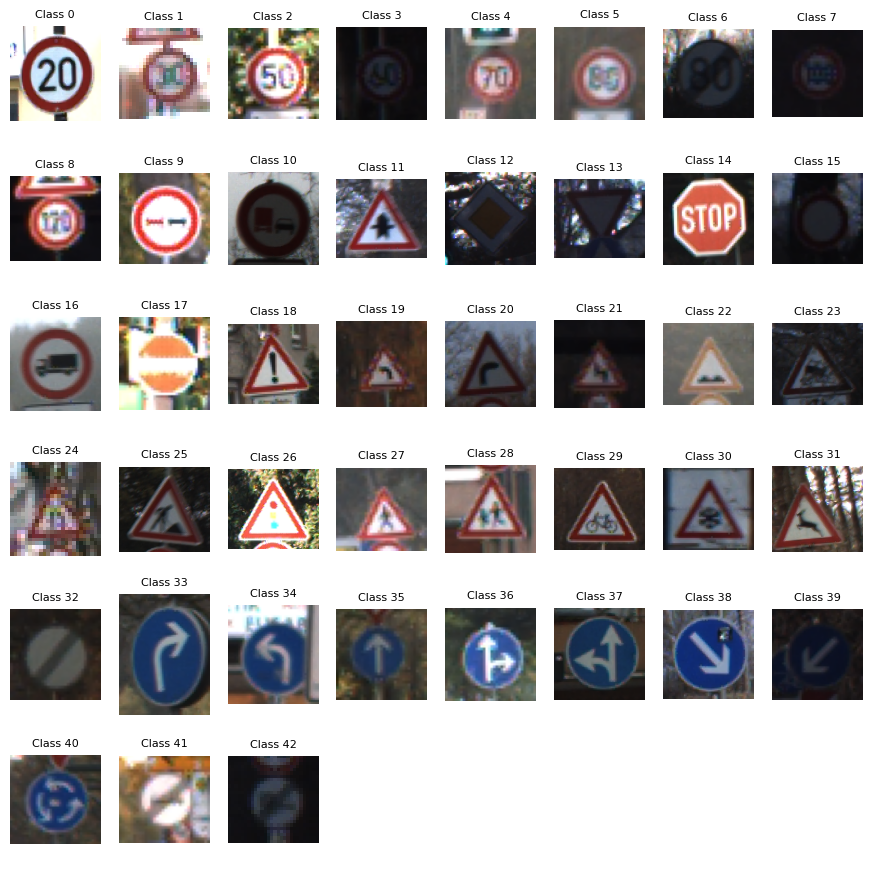

In [130]:
# Display a random selected image of each class from Train images
dl.display_train()

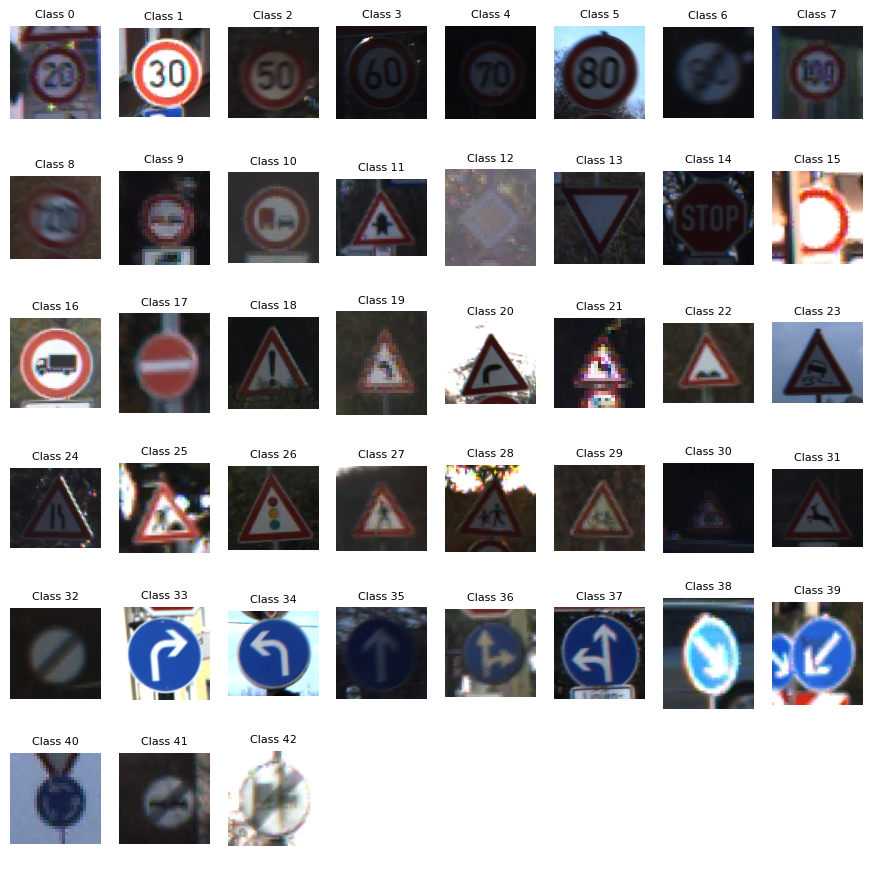

In [131]:
# Display a random selected image of each class from Test images
dl.display_test()

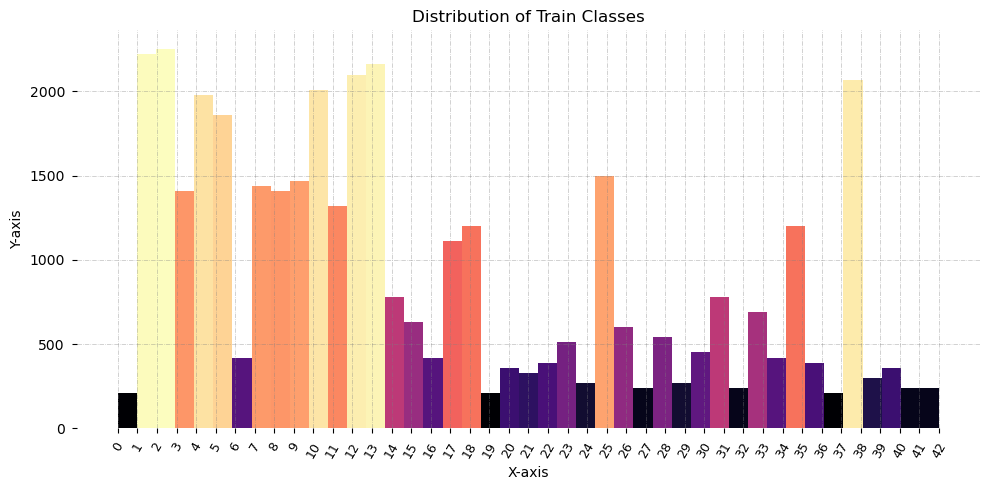

In [132]:
# Display class distribution of Train data
dl.display_distribution(train=True)


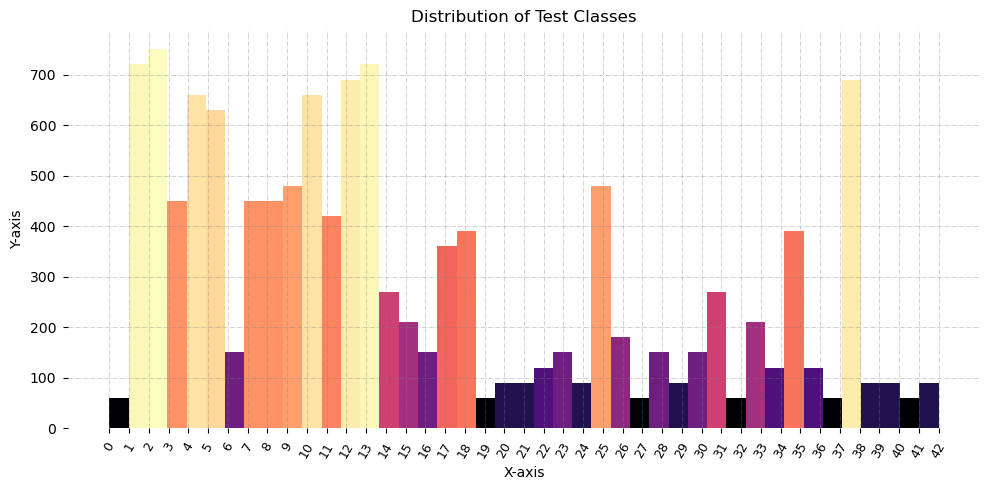

In [133]:
# Display class distribution of Train data
dl.display_distribution(train=False)


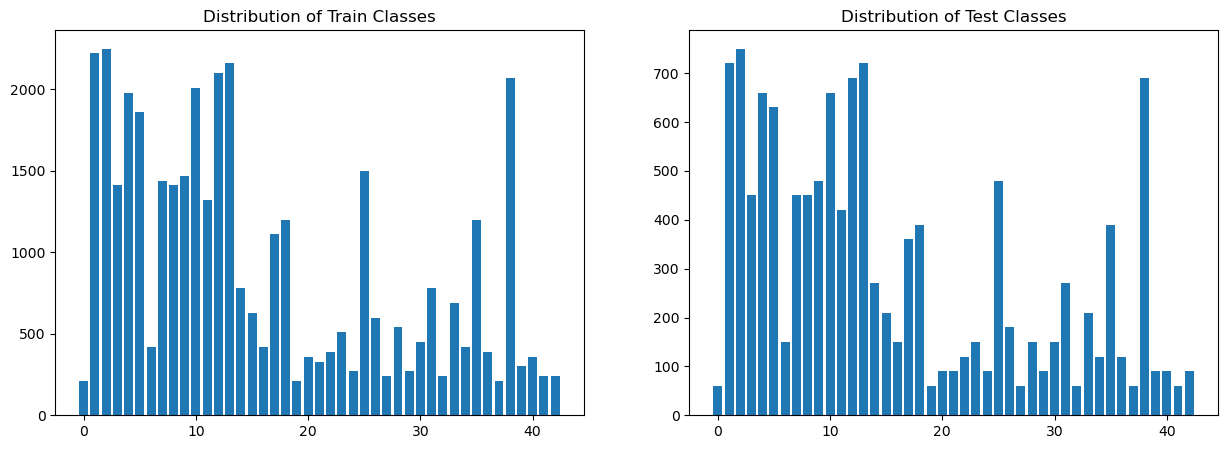

In [134]:
# Display a comparison class distribution between Train and Test
dl.display_train_test_distribution()

In [135]:
# Get image size for both, Train and Test
dl.image_size()

100%|███████████████████████████████████████████████████████████████████████████| 39209/39209 [00:09<00:00, 4095.43it/s]

Minimum size of train image:  (25, 25)
Maximum size of train image:  (243, 225)


In [136]:
# Get Train image size
image_size = dl.get_image_size(train=True)
print(f'Min size of train image: {image_size[0]}')
print(f'Max size of train image: {image_size[1]}')


100%|███████████████████████████████████████████████████████████████████████████| 39209/39209 [00:07<00:00, 5426.18it/s]

Min size of train image: (25, 25)
Max size of train image: (243, 225)


In [ ]:
# Get Test image size
image_size = dl.get_image_size(train=True)
print(f'Min size of train image: {image_size[0]}')
print(f'Max size of train image: {image_size[1]}')


In [137]:
# Get number of images for both, Train and Test images dataset
print(f'Number of Train images: {dl.train_rows}')
print(f'Number of Test images: {dl.test_rows}')


Number of Train images: 39209
Number of Test images: 12630


## Image Preprocessing

In [ ]:
# Class to preprocess images

class ImagePreproc:
    def __init__(self, odata):
        '''
        Class instanciation
        Input parameter: odata - Object of class DataLoad
        '''
        self.data = odata
        self.img_io = None
        
    def open_image(self, imgfile):
        self.img_io = tf.io.read_file(imgfile)
        return self.img_io
        
    def decode_image(self, img=self.img_io, channels=1):
        return tf.io.decode_png(img, channels=channels)

    def resize_image(self, img=self.img_io, width=32, height=32):
        return tf.image.resize(img, size=(width, height))
        
    def bright_image(self, img=self.img_io, brightness=0.3):
        return tf.image.adjust_brightness(img, brightness)
    
    def contrast_image(self, img=self.img_io, factor=3):
        return tf.image.adjust_contrast(img, contrast_factor=factor)
    
    def flip_image(self, img=self.img_io):
        return tf.image.flip_left_right(img)

    def distortion_free_resize(image, img_size=(32, 32)):
        w, h = img_size
        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

        # Check tha amount of padding needed to be done.
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]

        # add the same amount of padding on both sides.
        if pad_height % 2 != 0:
            height = pad_height // 2
            pad_height_top = height + 1
            pad_height_bottom = height
        else:
            pad_height_top = pad_height_bottom = pad_height // 2

        if pad_width % 2 != 0:
            width = pad_width // 2
            pad_width_left = width + 1
            pad_width_right = width
        else:
            pad_width_left = pad_width_right = pad_width // 2

        image = tf.pad(
            image,
            paddings=[
                [pad_height_top, pad_height_bottom],
                [pad_width_left, pad_width_right],
                [0, 0],
            ],
        )

        # To improve the model accuracy, use the following techniques to
        # adjust brightness, adjust contrast, transpose and flip the images
        image = tf.image.adjust_brightness(image, 0.3)
        image = tf.image.adjust_contrast(image, contrast_factor=3)
        image = tf.transpose(image, perm=[1, 0, 2])
        image = tf.image.flip_left_right(image)
        return image

## Feature Extraction

In [ ]:
RED = 0
GREEN = 1
BLUE = 2

# Class to extract image features
class ImageExtract:
    def __init__(self, opre):
        '''
        Class instanciation
        Input parameter: opre - Object of class ImagePreproc
        '''
        self.data = opreproc
        self.img = opreproc.img_io
        
    def get_colors_at(self, img=self.img, x=0, y=0):
        return (img[x,y,RED], img[x,y,GREEN], img[x,y,BLUE])
    
    def get_image_channel(self, img=self.img, channel=RED):
        return img[:,:,channel]
    
    def display_color_intensity(self, img=self.img):
        # Showing color intensity distribution in a histogram
        
        # Get red channel
        red_channel = self.get_image_channel(channel=RED)
        
        # Plot the red histogram with bins in a range of 256
        plt.hist(red_channel.ravel(), bins=256)
        # Set title and show
        plt.title('Red Histogram')
        plt.show()
        
        # Get green channel
        green_channel = self.get_image_channel(channel=GREEN)
        plt.hist(green_channel.ravel(), bins=256)
        plt.title('Green Histogram')
        plt.show()
        
        # GET blue channel
        blue_channel = self.get_image_channel(channel=BLUE)
        plt.hist(blue_channel.ravel(), bins=256)
        plt.title('Blue Histogram')
        plt.show()
        
        # Combined Histogram
        plt.hist(red_channel.ravel(), bins = 256, color = 'red', alpha = 0.5)
        plt.hist(green_channel.ravel(), bins = 256, color = 'green', alpha = 0.5)
        plt.hist(blue_channel.ravel(), bins = 256, color = 'blue', alpha = 0.5)
        plt.xlabel('Intensity Value')
        plt.ylabel('Count')
        plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
        plt.title('Combined Histogram')
        plt.show()
        
    def get_dominant_color(self, img=self.img):
        pass
    
    def detect_edges(self, img=self.img, horizontal=True):
        pass
    
    def get_corners(self, img=self.img):
        pass
    
    def get_HOG(self, img=self.img):
        pass
